In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import lime
import lime.lime_tabular
import shap
import time
import sys
sys.path.append('../../wrapper')
import xgboost

import mglearn
import sklearn
import sklearn.datasets

from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectPercentile

from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

from sklearn.svm import SVC
from sklearn import pipeline
from imblearn.under_sampling import RandomUnderSampler, ClusterCentroids

import matplotlib
import matplotlib.pyplot as plt

In [2]:
class Timer(object):
    def __init__(self, name=None):
        self.name = name

    def __enter__(self):
        self.tstart = time.time()

    def __exit__(self, type, value, traceback):
        if self.name:
            print ('[%s]' % self.name)
        print ('Elapsed: %s' % (time.time() - self.tstart))

In [92]:
R = np.random.RandomState(0)
df = pd.DataFrame(R.randint(low=1, high=10, size=(10000, 1)), columns=['a'])
df['b'] = R.randint(low=1, high=10, size=(10000, 1))
df['a*b'] = df.a * df.b
df['a/b'] = df.a / df.b
df['y'] = np.where(df['a*b']> 70, 'True', 'False')

for i in range(500):
    df[i+1] = R.randint(low=1, high=10, size=(10000, 1))
#df.plot.box()

In [93]:
df.groupby('y').count()

a     b   a*b   a/b     1     2     3     4     5     6  ...    491  \
y                                                                  ...          
False  9630  9630  9630  9630  9630  9630  9630  9630  9630  9630  ...   9630   
True    370   370   370   370   370   370   370   370   370   370  ...    370   

        492   493   494   495   496   497   498   499   500  
y                                                            
False  9630  9630  9630  9630  9630  9630  9630  9630  9630  
True    370   370   370   370   370   370   370   370   370  

[2 rows x 504 columns]

In [94]:
df.describe()

a             b          a*b           a/b             1  \
count  10000.000000  10000.000000  10000.00000  10000.000000  10000.000000   
mean       5.015300      4.947100     24.78830      1.605707      5.027300   
std        2.587187      2.571335     19.36129      1.761815      2.559455   
min        1.000000      1.000000      1.00000      0.111111      1.000000   
25%        3.000000      3.000000      8.00000      0.555556      3.000000   
50%        5.000000      5.000000     20.00000      1.000000      5.000000   
75%        7.000000      7.000000     36.00000      2.000000      7.000000   
max        9.000000      9.000000     81.00000      9.000000      9.000000   

                  2             3             4             5             6  \
count  10000.000000  10000.000000  10000.000000  10000.000000  10000.000000   
mean       5.011800      4.996400      4.981100      4.978700      4.992900   
std        2.573659      2.578498      2.568619      2.590621      2.579557   
min        1.000000      1.000000      1.000000      1.000000      1.000000   
25%        3.000000      3.000000      3.000000      3.000000      3.000000   
50%        5.000000      5.000000      5.000000      5.000000      5.000000   
75%        7.000000      7.000000      7.000000      7.000000      7.000000   
max        9.000000      9.000000      9.000000      9.000000      9.000000   

           ...                491           492           493           494  \
count      ...       10000.000000  10000.000000  10000.000000  10000.000000   
mean       ...           5.006700      4.980100      4.998900      4.987400   
std        ...           2.576028      2.577163      2.573045      2.591083   
min        ...           1.000000      1.000000      1.000000      1.000000   
25%        ...           3.000000      3.000000      3.000000      3.000000   
50%        ...           5.000000      5.000000      5.000000      5.000000   
75%        ...           7.000000      7.000000      7.000000      7.000000   
max        ...           9.000000      9.000000      9.000000      9.000000   

                495           496           497           498           499  \
count  10000.000000  10000.000000  10000.000000  10000.000000  10000.000000   
mean       5.022300      4.994200      4.985700      4.998200      5.000100   
std        2.591693      2.581401      2.590438      2.572325      2.562139   
min        1.000000      1.000000      1.000000      1.000000      1.000000   
25%        3.000000      3.000000      3.000000      3.000000      3.000000   
50%        5.000000      5.000000      5.000000      5.000000      5.000000   
75%        7.000000      7.000000      7.000000      7.000000      7.000000   
max        9.000000      9.000000      9.000000      9.000000      9.000000   

                500  
count  10000.000000  
mean       5.022600  
std        2.612771  
min        1.000000  
25%        3.000000  
50%        5.000000  
75%        7.000000  
max        9.000000  

[8 rows x 504 columns]

In [95]:
y = df.y
X = df.drop(['y'], 1)
feature_names = df.drop(['y'], 1).columns.values.tolist()
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)

In [96]:
le= sklearn.preprocessing.LabelEncoder()
le.fit(y)
labels = le.transform(y)
class_names = le.classes_
target_names = np.array(le.classes_)

In [97]:
rf = RandomForestClassifier(n_estimators=500, random_state=0)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [98]:
sklearn.metrics.accuracy_score(y_test, rf.predict(X_test))
print('Train score: {:.4f}'.format(rf.score(X_train, y_train)))
print('Test score: {:.4f}'.format(rf.score(X_test, y_test)))

Train score: 1.0000
Test score: 0.9635


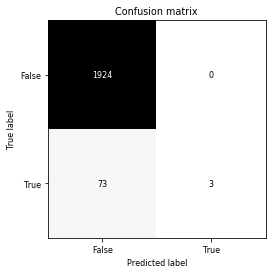

In [99]:
scores_image = mglearn.tools.heatmap(
    confusion_matrix(y_test, rf.predict(X_test)), xlabel='Predicted label',
    ylabel='True label', xticklabels=target_names,
    yticklabels=target_names, cmap=plt.cm.gray_r, fmt="%d")    
plt.title("Confusion matrix")
plt.gca().invert_yaxis()

### Random under-sampling

In [280]:
rus = RandomUnderSampler(random_state=0)
#rus = ClusterCentroids(random_state=0)
X_sampled, y_sampled = rus.fit_sample(X, y)
print('X_resampled.shape: {}, y_resampled: {}'.format(X_sampled.shape, y_sampled.shape))
print('y_resample:\n{}'.format(pd.Series(y_sampled).value_counts()))

X_resampled.shape: (740, 504), y_resampled: (740,)
y_resample:
False    370
True     370
dtype: int64


In [276]:
X_train_sampled, X_test_sampled, y_train_sampled, y_test_sampled = train_test_split(X_sampled, y_sampled, train_size=0.80, test_size=0.2, random_state=0)
rf.fit(X_sampled, y_sampled)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [281]:
sklearn.metrics.accuracy_score(y_test_sampled, rf.predict(X_test_sampled))
print('Train score: {:.4f}'.format(rf.score(X_train_sampled, y_train_sampled)))
print('Test score: {:.4f}'.format(rf.score(X_test_sampled, y_test_sampled)))

Train score: 1.0000
Test score: 1.0000


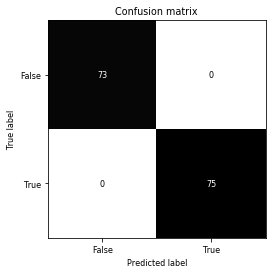

In [282]:
scores_image = mglearn.tools.heatmap(
    confusion_matrix(y_test_sampled, rf.predict(X_test_sampled)), xlabel='Predicted label',
    ylabel='True label', xticklabels=target_names,
    yticklabels=target_names, cmap=plt.cm.gray_r, fmt="%d")    
plt.title("Confusion matrix")
plt.gca().invert_yaxis()

In [169]:
X_train_sampled = pd.DataFrame(X_train_sampled, columns=list(X_train))
X_test_sampled = pd.DataFrame(X_test_sampled, columns=list(X_train))

### Feature selection

In [170]:
select = SelectFromModel(
    RandomForestClassifier(n_estimators=500, random_state=0),
    threshold="2*median")
#    threshold="6.7*median")

In [171]:
select.fit(X_train_sampled, y_train_sampled)
#X_train_selected = select.transform(X_train_sampled)
idxs_selected = select.get_support(indices=True)
X_train_selected = X_train_sampled.iloc[:, idxs_selected]

#X_test_selected = select.transform(X_test_sampled)
#idxs_selected = select.get_support(indices=True)
X_test_selected = X_test_sampled.iloc[:, idxs_selected]

print("X_train.shape: {}".format(X_train_sampled.shape))
print("X_train_selected.shape: {}".format(X_train_selected.shape))
print("X_test_selected.shape: {}".format(X_test_selected.shape))

X_train.shape: (592, 504)
X_train_selected.shape: (592, 13)
X_test_selected.shape: (148, 13)


In [172]:
feature_importances = select.estimator_.feature_importances_[idxs_selected]
idx = sorted(range(len(feature_importances)), key=lambda k: feature_importances[k])

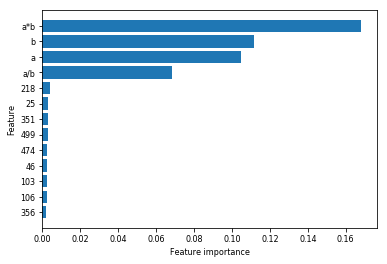

In [173]:
def plot_feature_importances(model):
    n_features = X_train_selected.shape[1]
    plt.barh(range(n_features), sorted(feature_importances), align='center')
    plt.yticks(np.arange(n_features), np.array(list(X_train_selected))[idx])
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)

plt.rcParams.update({'font.size': 8})
plot_feature_importances(select)

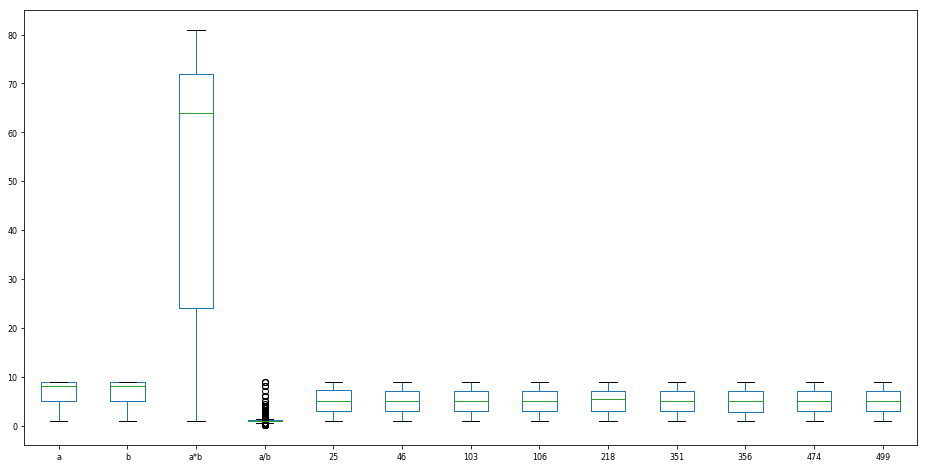

In [174]:
X_train_selected.plot.box(figsize=(16,8))

In [226]:
svm_fail = SVC(probability=True)
svm_fail.fit(X_train_selected, y_train_sampled)
sklearn.metrics.accuracy_score(y_test_sampled, svm_fail.predict(X_test_selected))
print('Train score: {:.4f}'.format(svm_fail.score(X_train_selected, y_train_sampled)))
print('Test score: {:.4f}'.format(svm_fail.score(X_test_selected, y_test_sampled)))

Train score: 1.0000
Test score: 0.8986


In [175]:
svm = SVC(C=100, gamma=0.01, probability=True)
svm.fit(X_train_selected, y_train_sampled)
sklearn.metrics.accuracy_score(y_test_sampled, svm.predict(X_test_selected))
print('Train score: {:.4f}'.format(svm.score(X_train_selected, y_train_sampled)))
print('Test score: {:.4f}'.format(svm.score(X_test_selected, y_test_sampled)))

Train score: 1.0000
Test score: 1.0000


In [176]:
pipe_svm_stdscaler = pipeline.Pipeline([('preprocessing', StandardScaler()), ('classifier', SVC(C=100, gamma=0.01, probability=True))])
pipe_svm_stdscaler.fit(X_train_selected, y_train_sampled)
print('Train score: {:.4f}'.format(pipe_svm_stdscaler.score(X_train_selected, y_train_sampled)))
print("Test set score: {:.3f}".format(pipe_svm_stdscaler.score(X_test_selected, y_test_sampled)))

Train score: 1.0000
Test set score: 1.000


In [221]:
pipe_svm_stdscaler_fail = pipeline.Pipeline([('preprocessing', StandardScaler()), ('classifier', SVC(C=0.1, gamma=0.01, probability=True))])
pipe_svm_stdscaler_fail.fit(X_train_selected, y_train_sampled)
print('Train score: {:.4f}'.format(pipe_svm_stdscaler_fail.score(X_train_selected, y_train_sampled)))
print("Test set score: {:.3f}".format(pipe_svm_stdscaler_fail.score(X_test_selected, y_test_sampled)))

Train score: 0.9071
Test set score: 0.939


In [177]:
pipe_svm_minmax = pipeline.Pipeline([('preprocessing', MinMaxScaler()), ('classifier', SVC(C=100, gamma=0.1, probability=True))])
pipe_svm_minmax.fit(X_train_selected, y_train_sampled)
print('Train score: {:.4f}'.format(pipe_svm_minmax.score(X_train_selected, y_train_sampled)))
print("Test set score: {:.3f}".format(pipe_svm_minmax.score(X_test_selected, y_test_sampled)))

Train score: 1.0000
Test set score: 1.000


In [214]:
rf = RandomForestClassifier()
rf.fit(X_train_selected, y_train_sampled)
sklearn.metrics.accuracy_score(y_test_sampled, rf.predict(X_test_selected))
print('Train score: {:.4f}'.format(rf.score(X_train_selected, y_train_sampled)))
print('Test score: {:.4f}'.format(rf.score(X_test_selected, y_test_sampled)))

Train score: 1.0000
Test score: 1.0000


In [211]:
rf_500 = RandomForestClassifier(n_estimators=500)
rf_500.fit(X_train_selected, y_train_sampled)
sklearn.metrics.accuracy_score(y_test_sampled, rf_500.predict(X_test_selected))
print('Train score: {:.4f}'.format(rf_500.score(X_train_selected, y_train_sampled)))
print('Test score: {:.4f}'.format(rf_500.score(X_test_selected, y_test_sampled)))

Train score: 1.0000
Test score: 1.0000


In [179]:
pipe_rf_stdscaler = pipeline.Pipeline([('preprocessing', StandardScaler()), ('classifier', RandomForestClassifier())])
pipe_rf_stdscaler.fit(X_train_selected, y_train_sampled)
print('Train score: {:.4f}'.format(pipe_rf_stdscaler.score(X_train_selected, y_train_sampled)))
print("Test set score: {:.3f}".format(pipe_rf_stdscaler.score(X_test_selected, y_test_sampled)))

Train score: 1.0000
Test set score: 1.000


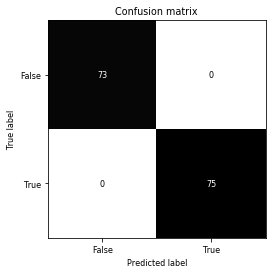

In [180]:
target_names = np.array(le.classes_)
scores_image = mglearn.tools.heatmap(
    confusion_matrix(y_test_sampled, rf.predict(X_test_selected)), xlabel='Predicted label',
    ylabel='True label', xticklabels=target_names,
    yticklabels=target_names, cmap=plt.cm.gray_r, fmt="%d")    
plt.title("Confusion matrix")
plt.gca().invert_yaxis()

In [216]:
rf_10 = RandomForestClassifier(n_estimators=1)
rf_10.fit(X_train_selected, y_train_sampled)
sklearn.metrics.accuracy_score(y_test_sampled, rf_10.predict(X_test_selected))
print('Train score: {:.4f}'.format(rf_10.score(X_train_selected, y_train_sampled)))
print('Test score: {:.4f}'.format(rf_10.score(X_test_selected, y_test_sampled)))

Train score: 1.0000
Test score: 1.0000


### SHAP explaining predictions after under-sampling

In [117]:
X_test_sampled = pd.DataFrame(X_test_sampled, columns=feature_names)

In [137]:
explainer = shap.KernelExplainer(rf.predict_proba, X_train_selected)
shap_values_rf = explainer.shap_values(pd.DataFrame(X_test_selected))

100%|██████████| 148/148 [32:43<00:00, 13.27s/it]


In [212]:
explainer = shap.KernelExplainer(rf_500.predict_proba, X_train_selected)
shap_values_rf_500 = explainer.shap_values(pd.DataFrame(X_test_selected))

100%|██████████| 148/148 [1:09:44<00:00, 28.28s/it]


In [121]:
explainer = shap.KernelExplainer(pipe_rf_stdscaler.predict_proba, X_train_selected)
shap_values_rf_stdscaler = explainer.shap_values(pd.DataFrame(X_test_selected))

100%|██████████| 148/148 [36:18<00:00, 14.72s/it]


In [132]:
explainer = shap.KernelExplainer(svm.predict_proba, X_train_selected)
shap_values_svm = explainer.shap_values(pd.DataFrame(X_test_selected))

100%|██████████| 148/148 [40:52<00:00, 16.57s/it]


In [134]:
explainer = shap.KernelExplainer(pipe_svm_stdscaler.predict_proba, X_train_selected)
shap_values_svm_stdscaler = explainer.shap_values(pd.DataFrame(X_test_selected))

100%|██████████| 148/148 [37:29<00:00, 15.20s/it]


In [227]:
explainer = shap.KernelExplainer(svm_fail.predict_proba, X_train_selected)
shap_values_svm_fail = explainer.shap_values(pd.DataFrame(X_test_selected))

100%|██████████| 148/148 [54:17<00:00, 22.01s/it]


In [136]:
explainer = shap.KernelExplainer(pipe_svm_minmax.predict_proba, X_train_selected)
shap_values_svm_minmax = explainer.shap_values(pd.DataFrame(X_test_selected))

100%|██████████| 148/148 [55:59<00:00, 22.70s/it] 


In [162]:
explainer = shap.KernelExplainer(rf.predict_proba, X_train_selected)
shap_values_rf_cluster = explainer.shap_values(pd.DataFrame(X_test_selected))

100%|██████████| 148/148 [30:42<00:00, 12.45s/it]


In [229]:
shap.initjs()

In [236]:
i = 5
shap.force_plot(shap_values_rf[1][i], pd.DataFrame(X_test_selected).iloc[i,:])

In [271]:
shap.force_plot(shap_values_rf_500[1], pd.DataFrame(X_test_selected))

In [ ]:
pipe_svm_stdscaler
pipe_svm_minmax
pipe_rf_stdscaler

### SHAP explanation of SVM with Random undersampling

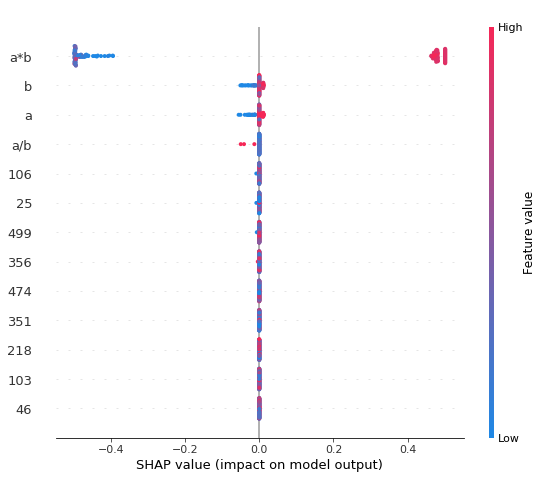

In [133]:
shap.summary_plot(shap_values_svm[1], pd.DataFrame(X_test_selected))

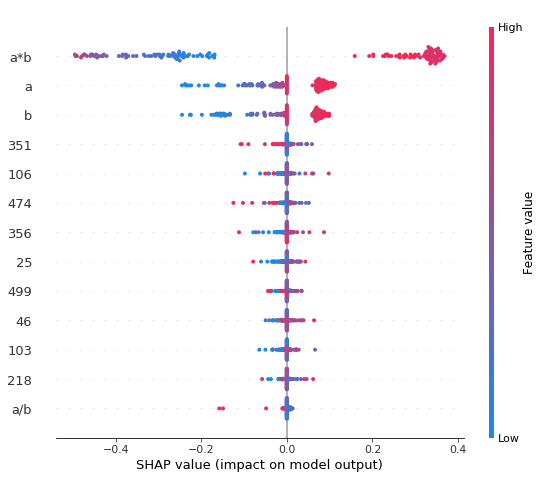

In [228]:
shap.summary_plot(shap_values_svm_fail[1], pd.DataFrame(X_test_selected))

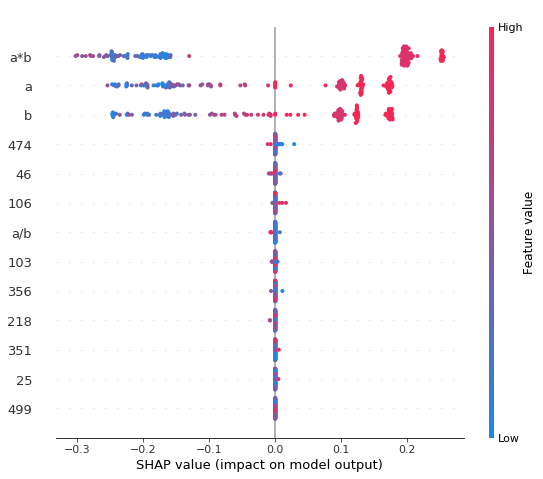

In [135]:
shap.summary_plot(shap_values_svm_stdscaler[1], pd.DataFrame(X_test_selected))

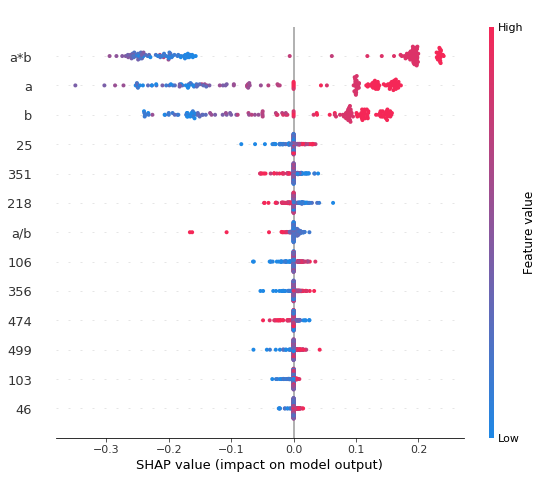

In [189]:
shap.summary_plot(shap_values_svm_stdscaler_fail[1], pd.DataFrame(X_test_selected))

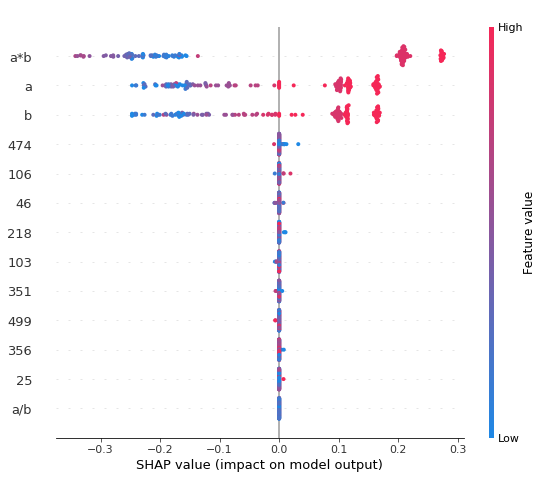

In [182]:
shap.summary_plot(shap_values_svm_minmax[1], pd.DataFrame(X_test_selected))

### SHAP explanation of Random Forests with Random undersampling

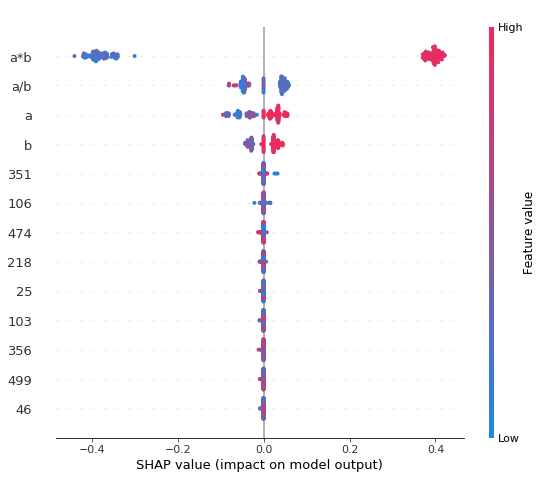

In [245]:
shap.summary_plot(shap_values_rf[1], pd.DataFrame(X_test_selected))

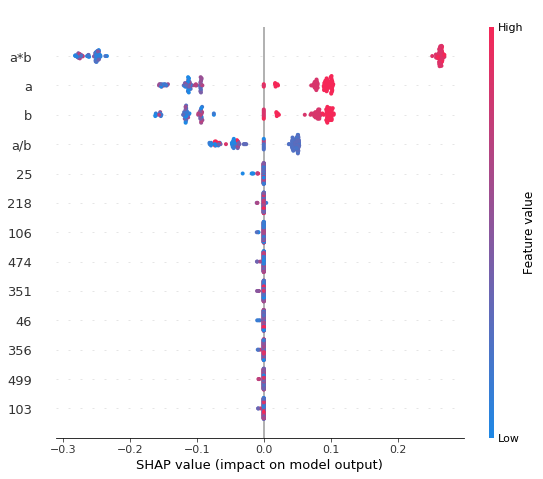

In [213]:
shap.summary_plot(shap_values_rf_500[1], pd.DataFrame(X_test_selected))

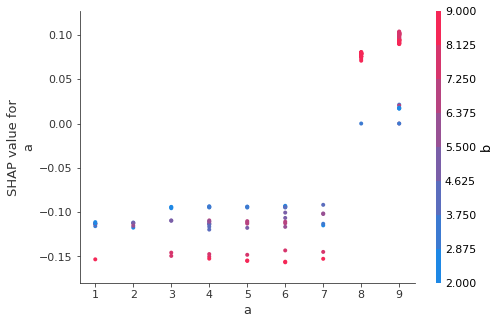

In [267]:
shap.dependence_plot("a", shap_values_rf_500[1], X_test_selected)

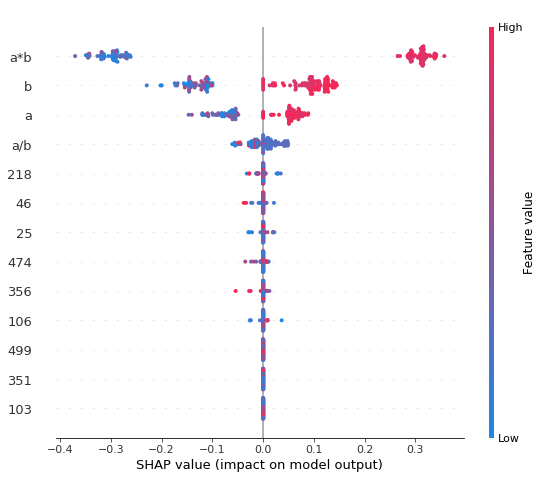

In [123]:
shap.summary_plot(shap_values_rf_stdscaler[1], pd.DataFrame(X_test_selected))

### SHAP explanation of Random Forests with Cluster Centroid undersampling

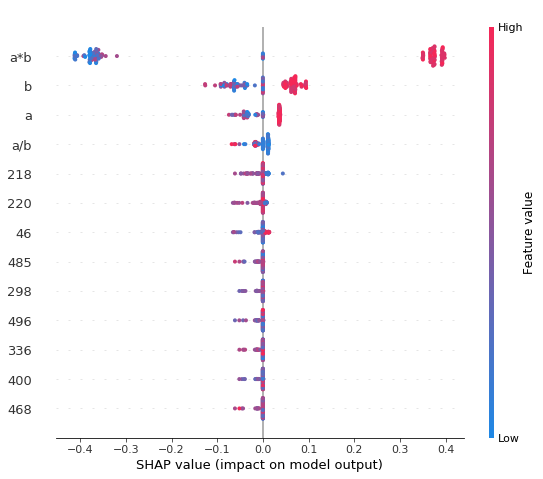

In [164]:
shap.summary_plot(shap_values_rf_cluster[1], pd.DataFrame(X_test_selected))

### SHAP explaining predictions of XGBoost

In [191]:
xgb_train = xgboost.DMatrix(X_train_selected, label=le.transform(y_train_sampled))
xgb_test = xgboost.DMatrix(X_test_selected, label=le.transform(y_test_sampled))

In [257]:
# use validation set to choose # of trees
params = {#'max_depth':20, 'n_estimators':100,
         'objective': 'multi:softmax', 'num_class': 2
}

xgb = xgboost.train(params, xgb_train, 1)

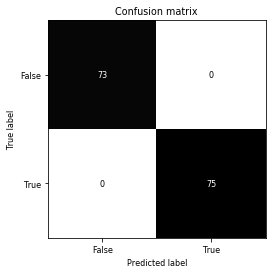

In [258]:
target_names = np.array(le.classes_)
scores_image = mglearn.tools.heatmap(
    confusion_matrix(le.transform(y_test_sampled), xgb.predict(xgb_test)), xlabel='Predicted label',
    ylabel='True label', xticklabels=target_names,
    yticklabels=target_names, cmap=plt.cm.gray_r, fmt="%d")    
plt.title("Confusion matrix")
plt.gca().invert_yaxis()

In [259]:
shap_values_xgb = xgb.predict(xgb_test, pred_contribs=True)

### SHAP explanation of XGBoost with Random undersampling

In [260]:
shap_interaction_values = xgb.predict(xgb_test, pred_interactions=True)

In [261]:
X_test_selected.columns = X_test_selected.columns.astype(str)

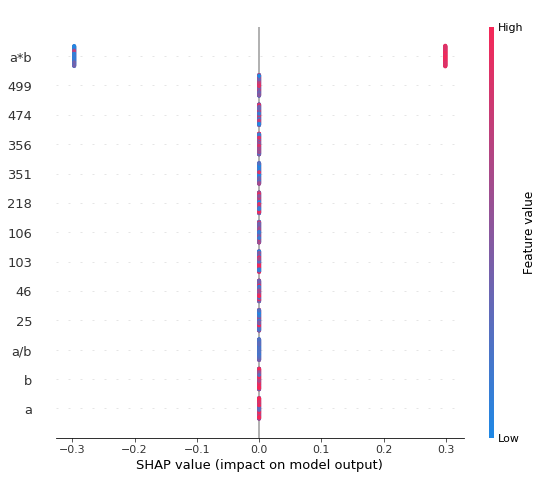

In [262]:
shap.summary_plot(shap_values_xgb[:, 1, :], X_test_selected)

/Users/lillian/anaconda3/lib/python3.5/site-packages/numpy/lib/function_base.py:3003: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/lillian/anaconda3/lib/python3.5/site-packages/numpy/lib/function_base.py:3004: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/lillian/anaconda3/lib/python3.5/site-packages/shap/plots.py:236: RuntimeWarning: invalid value encountered in absolute
  return np.argsort(-np.abs(interactions))


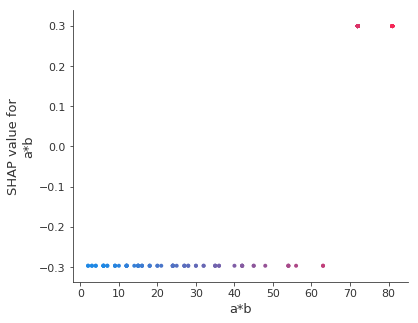

In [265]:
shap.dependence_plot("a*b", shap_values_xgb[:, 1, :], X_test_selected)

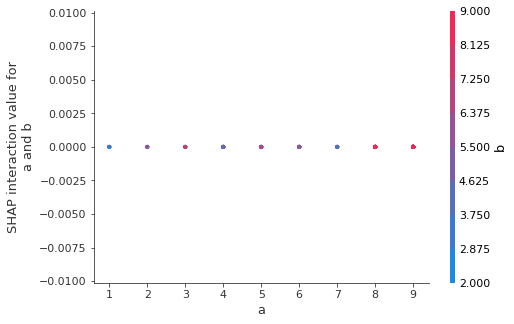

In [204]:
shap.dependence_plot(
    ("a", "b"),
    shap_interaction_values[:, 1, :, :], X_test_selected,
    display_features=X_test_selected
)

### LIME explaining predictions

In [24]:
explainer = lime.lime_tabular.LimeTabularExplainer(np.array(X_train), feature_names=feature_names, class_names=class_names, discretize_continuous=True)

In [25]:
results = pd.DataFrame(rf.predict(X_test), columns=['predict'])
true = results.index[results['predict']=="True"].tolist()
true

[128, 279, 394, 787, 859, 874, 1096, 1103, 1260, 1284, 1511, 1603, 1811, 1999]

In [27]:
for i in [786, 787]:
    with Timer('LIME'):
        exp = explainer.explain_instance(np.array(X_test)[i], rf.predict_proba, num_features=5)#, top_labels=2)
    exp.show_in_notebook(show_table=True, show_all=True)

[LIME]
Elapsed: 18.50564193725586


[LIME]
Elapsed: 18.90460515022278


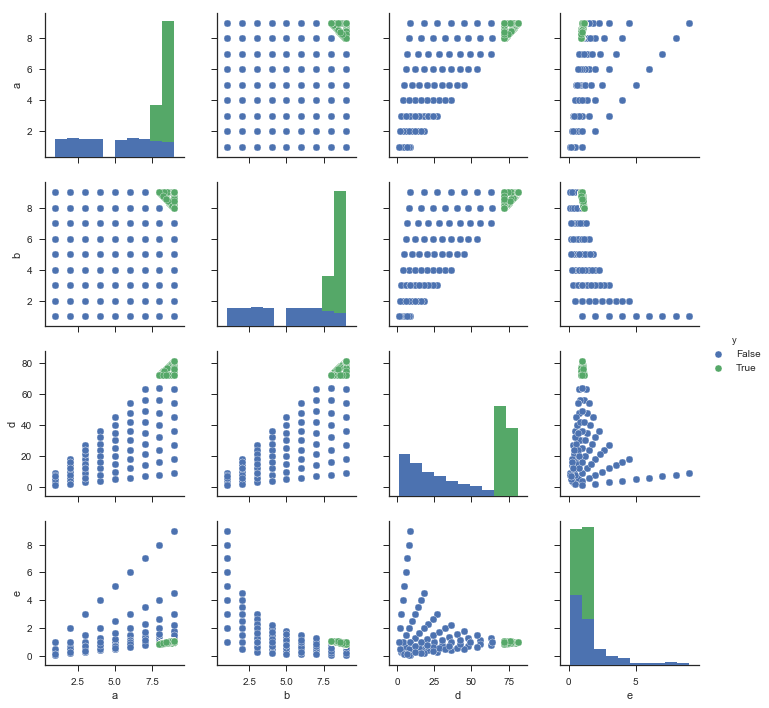

In [161]:
import seaborn as sns
sns.set(style="ticks")
X_train_selected_SMOTE = pd.DataFrame(X_train_selected)
X_train_selected_SMOTE['y'] = y_train_sampled
sns.pairplot(X_train_selected_SMOTE[['a', 'b', 'd', 'e', 'y']], hue="y")

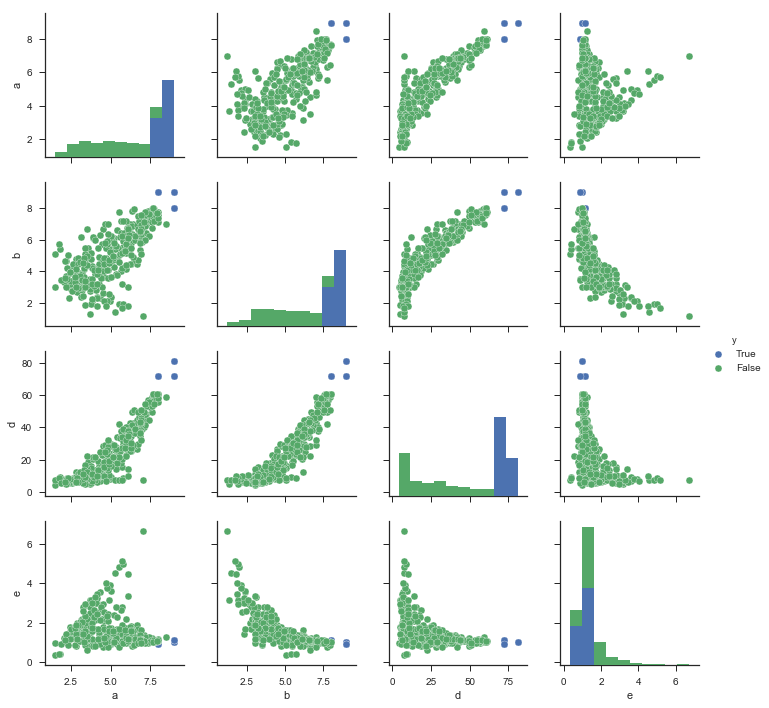

In [145]:
import seaborn as sns
sns.set(style="ticks")
X_train_selected_cluster = pd.DataFrame(X_train_selected)
X_train_selected_cluster['y'] = y_train_sampled
sns.pairplot(X_train_selected_cluster[['a', 'b', 'd', 'e', 'y']], hue="y")

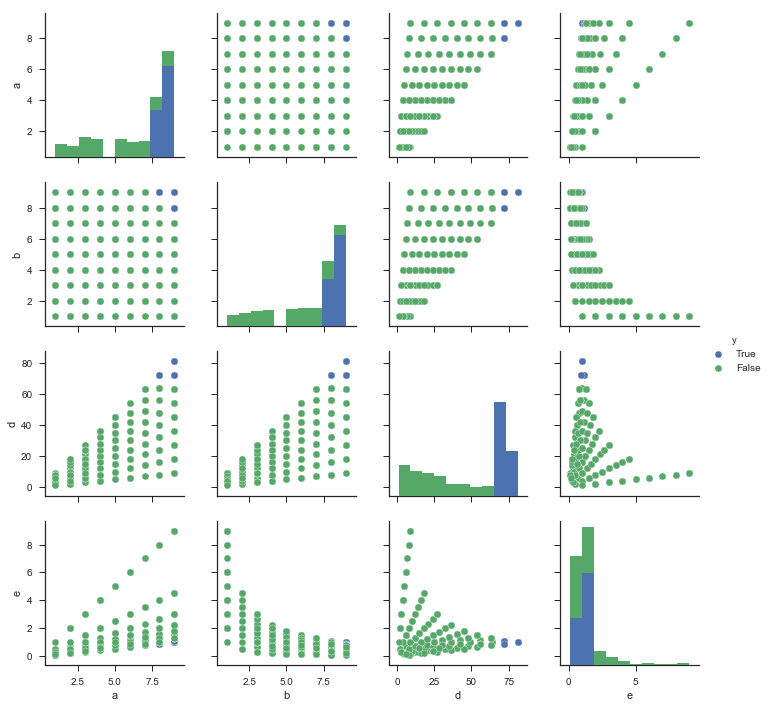

In [126]:
import seaborn as sns
sns.set(style="ticks")
X_train_selected_random = pd.DataFrame(X_train_selected)
X_train_selected_random['y'] = y_train_sampled
sns.pairplot(X_train_selected_random[['a', 'b', 'd', 'e', 'y']], hue="y")